Versão 12DEZV6 - Com os melhores parâmetros obtidos

In [1]:
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
import datetime as dt

In [2]:
epochs = 20
batch_size = 50
image_size = (128, 128)
images_m = Path('../dataset/maleeyes')
images_f = Path('../dataset/femaleeyes')
seed = 88

## 1. Importar o dataset

In [3]:
fem_paths = list(images_f.glob(r'**/*.jpg'))
#print(fem_paths)
mal_paths = list(images_m.glob(r'**/*.jpg'))

Convertemos os labels em valores numéricos, para serem utilizados no modelo.

In [4]:
fm_labels = list(map(lambda x: "0", fem_paths)) # 0 para female
#print(fm_labels)
mal_labels = list(map(lambda x: "1", mal_paths)) # 1 para male

In [5]:
fm_filepaths = pd.Series(fem_paths, name = 'File').astype(str)
fm_labels = pd.Series(fm_labels, name='Label')
female_df = pd.concat([fm_filepaths, fm_labels], axis=1)
female_df.head()

,File,Label
0,..\dataset\femaleeyes\1.jpg,0
1,..\dataset\femaleeyes\10.jpg,0
2,..\dataset\femaleeyes\100.jpg,0
3,..\dataset\femaleeyes\1000.jpg,0
4,..\dataset\femaleeyes\1001.jpg,0


In [6]:
mal_filepaths = pd.Series(mal_paths, name = 'File').astype(str)
mal_labels = pd.Series(mal_labels, name='Label')
male_df = pd.concat([mal_filepaths, mal_labels], axis=1)
male_df.head()

,File,Label
0,..\dataset\maleeyes\0.jpg,1
1,..\dataset\maleeyes\1.jpg,1
2,..\dataset\maleeyes\10.jpg,1
3,..\dataset\maleeyes\100.jpg,1
4,..\dataset\maleeyes\1000.jpg,1


In [7]:
# Vamos juntar os dois dataframes
df = pd.concat([female_df, male_df])

In [8]:
df.value_counts()

File                            Label
..\dataset\femaleeyes\1.jpg     0        1
..\dataset\maleeyes\3649.jpg    1        1
..\dataset\maleeyes\3650.jpg    1        1
..\dataset\maleeyes\3651.jpg    1        1
..\dataset\maleeyes\3652.jpg    1        1
                                        ..
..\dataset\femaleeyes\600.jpg   0        1
..\dataset\femaleeyes\6001.jpg  0        1
..\dataset\femaleeyes\6002.jpg  0        1
..\dataset\femaleeyes\6003.jpg  0        1
..\dataset\maleeyes\998.jpg     1        1
Length: 11525, dtype: int64

Vamos verificar o balanceamento das classes.

<AxesSubplot:title={'center':'Balanço entre as classes female e male'}, xlabel='Label', ylabel='count'>

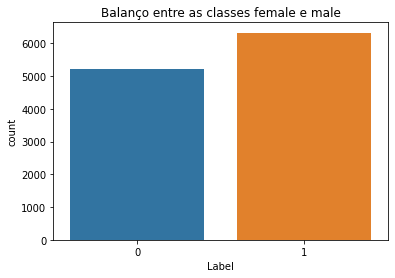

In [9]:
plt.title("Balanço entre as classes female e male")
sns.countplot(data=df, x = "Label")

Verificamos que existem mais imagens de homens do que mulheres, no entanto o dataset não está demasiado desiquilibrado neste aspeto.

## 2. Dividir em treino, validação e teste

Vamos dividir o dataset em treino, validação e teste. Para isso, dividimos primeiro em treino e teste (80% e 20% respetivamente). Depois usamos parte do dataset de treino para validação (20% do dataset de treino).

In [10]:
train_df, test_df = train_test_split(df, train_size = 0.80, random_state = 88)

In [11]:
train_df.head()

,File,Label
826,..\dataset\femaleeyes\2108.jpg,0
665,..\dataset\maleeyes\1698.jpg,1
1883,..\dataset\femaleeyes\3440.jpg,0
4198,..\dataset\maleeyes\547.jpg,1
272,..\dataset\femaleeyes\1358.jpg,0


In [12]:
def get_split_data(use_data_aug):
    if use_data_aug:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2, rotation_range=10, horizontal_flip ='true')
    else:
        train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

    test_datagen = ImageDataGenerator(rescale=1./255.)
    train_ds = train_datagen.flow_from_dataframe(dataframe = train_df, x_col = "File", y_col = "Label", target_size = (128, 128),
        color_mode = "rgb", class_mode = "binary", batch_size = 50, shuffle = True, seed = 88, subset = "training")

    val_ds = train_datagen.flow_from_dataframe(dataframe = train_df, x_col = "File", y_col = "Label", target_size = (128, 128),
            color_mode ="rgb", class_mode = "binary", batch_size = 50, shuffle = True, seed = 88, subset = "validation")

    test_ds = test_datagen.flow_from_dataframe(dataframe = test_df, x_col = "File", y_col = "Label", target_size = (128, 128),
                                               color_mode ="rgb", class_mode = "binary", shuffle = False, batch_size = 50)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_split_data(False)

Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.


### Exemplos de imagens do dataset

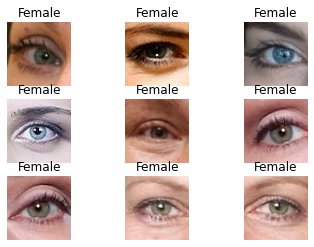

In [14]:
i = 0
for row in df.head(9).itertuples():
    ax = plt.subplot(3, 3, i + 1)
    img = mpimg.imread(row[1])
    plt.imshow(img)
    if int(row[2]) == 0:
        plt.title("Female")
    else:
        plt.title("Male")
    plt.axis("off")
    i += 1

### Introdução de data augmentation

In [15]:
train_ds_aug, val_ds_aug, test_ds_aug = get_split_data(True)

Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.


### Alguns exemplos de imagens com data augmentation

Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.
Labels: [0.0, 1.0, 0.0, 1.0, 1.0]


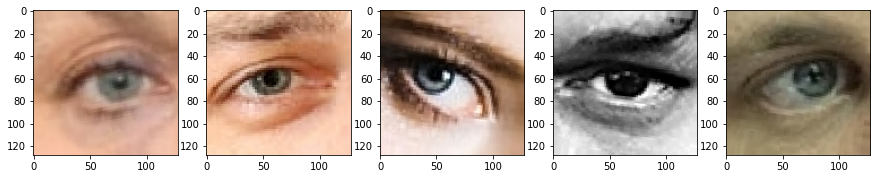

In [16]:
train_ds, val_ds, test_ds = get_split_data(True)
eyes = [next(train_ds_aug) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in eyes])
l = [ax[i].imshow(eyes[i][0][0]) for i in range(0,5)]

## 3. Modelos de aprendizagem automática

In [17]:
# Função para fazermos plot das accuracy e loss dos vários modelos
def plot_accuracy(model_history):
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')

    plt.legend()

    plt.show()

In [18]:
def evaluate_model(model, test_set, df_test):
    y_pred = model.predict(test_set)
    predicted_categories = tf.math.round(y_pred)
    predicted_categories = [int(y) for x in predicted_categories for y in x]
    labels = [int(x) for x in df_test['Label']]
    print(classification_report(labels, predicted_categories))
    return predicted_categories, labels


In [19]:
def plot_missed_images(predicted_results, correct_results, df):
    num_images = 0
    for index, (first, second) in enumerate(zip(predicted_results, correct_results)):
        if first != second:
            ax = plt.subplot(3, 3, num_images + 1)
            file = df.iloc[index]['File']
            plt.imshow(mpimg.imread(file))
            if second == 0:
                plt.title("Female")
            else:
                plt.title("Male")
            plt.axis("off")
            num_images +=1
            if num_images == 8: 
                break
                

### 3.1 CNN desenvolvida sem data_augmentation e sem dropout

In [20]:
cnn_1 = tf.keras.models.Sequential([
    layers.Conv2D(32, (4, 4), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [21]:
# Vamos fazer o summary do modelo
cnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

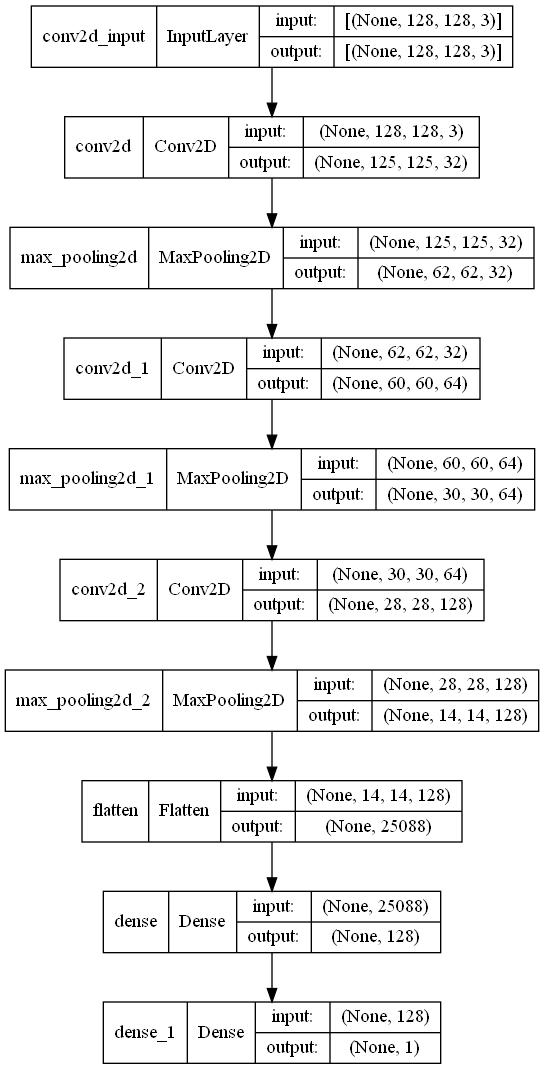

In [22]:
#Faz um plot
plot_model(cnn_1, to_file='model.png', show_layer_names = True , show_shapes = True)

In [23]:
start = dt.datetime.now()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
callbacks = [ keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
cnn_1.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
cnn_1_history = cnn_1.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

end = dt.datetime.now()
time_CNN_1 = end - start
print("O treino do modelo demorou " + str(time_CNN_1))

Epoch 1/20
148/148 [==============================] - 81s 547ms/step - loss: 0.5719 - accuracy: 0.6921 - val_loss: 0.4396 - val_accuracy: 0.7966
Epoch 2/20
148/148 [==============================] - 75s 509ms/step - loss: 0.3857 - accuracy: 0.8332 - val_loss: 0.4540 - val_accuracy: 0.7950
Epoch 3/20
148/148 [==============================] - 72s 484ms/step - loss: 0.3546 - accuracy: 0.8468 - val_loss: 0.3285 - val_accuracy: 0.8628
Epoch 4/20
148/148 [==============================] - 75s 507ms/step - loss: 0.3013 - accuracy: 0.8745 - val_loss: 0.2838 - val_accuracy: 0.8867
Epoch 5/20
148/148 [==============================] - 83s 561ms/step - loss: 0.2815 - accuracy: 0.8841 - val_loss: 0.2879 - val_accuracy: 0.8867
Epoch 6/20
148/148 [==============================] - 73s 489ms/step - loss: 0.2676 - accuracy: 0.8902 - val_loss: 0.2708 - val_accuracy: 0.8943
Epoch 7/20
148/148 [==============================] - 72s 484ms/step - loss: 0.2496 - accuracy: 0.8961 - val_loss: 0.2686 - val_ac

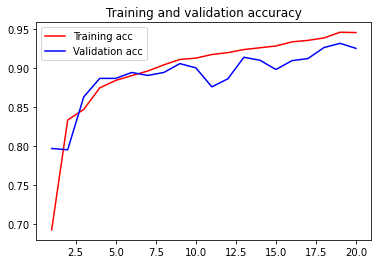

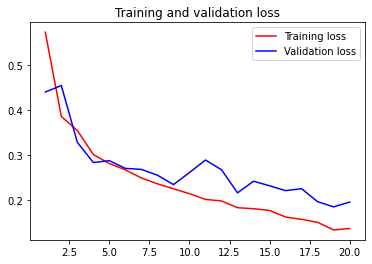

In [24]:
plot_accuracy(cnn_1_history)

In [25]:
cnn_1_pred_labels, labels = evaluate_model(cnn_1, test_ds, test_df)

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1046
           1       0.93      0.94      0.94      1259

    accuracy                           0.93      2305
   macro avg       0.93      0.93      0.93      2305
weighted avg       0.93      0.93      0.93      2305



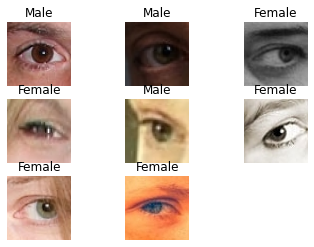

In [26]:
plot_missed_images(cnn_1_pred_labels, labels, test_df)

### 3.1.2 CNN Desenvolvida com data_augmentation e dropout

In [27]:
cnn_2 = tf.keras.models.Sequential([
    layers.Conv2D(32, (4, 4), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [28]:
start = dt.datetime.now()

cnn_2.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
cnn_2_history = cnn_2.fit(train_ds_aug, epochs=epochs, callbacks=callbacks, validation_data=val_ds_aug)

end = dt.datetime.now()
time_CNN_2 = end - start
print("O treino do modelo demorou " + str(time_CNN_2))

Epoch 1/20
148/148 [==============================] - 76s 512ms/step - loss: 0.5367 - accuracy: 0.7190 - val_loss: 0.4350 - val_accuracy: 0.7912
Epoch 2/20
148/148 [==============================] - 75s 508ms/step - loss: 0.3846 - accuracy: 0.8304 - val_loss: 0.3825 - val_accuracy: 0.8324
Epoch 3/20
148/148 [==============================] - 76s 509ms/step - loss: 0.3345 - accuracy: 0.8539 - val_loss: 0.2900 - val_accuracy: 0.8894
Epoch 4/20
148/148 [==============================] - 76s 515ms/step - loss: 0.2845 - accuracy: 0.8839 - val_loss: 0.3244 - val_accuracy: 0.8628
Epoch 5/20
148/148 [==============================] - 78s 525ms/step - loss: 0.2786 - accuracy: 0.8880 - val_loss: 0.2892 - val_accuracy: 0.8688
Epoch 6/20
148/148 [==============================] - 76s 512ms/step - loss: 0.2548 - accuracy: 0.8949 - val_loss: 0.2414 - val_accuracy: 0.8964
Epoch 7/20
148/148 [==============================] - 78s 524ms/step - loss: 0.2238 - accuracy: 0.9085 - val_loss: 0.2338 - val_ac

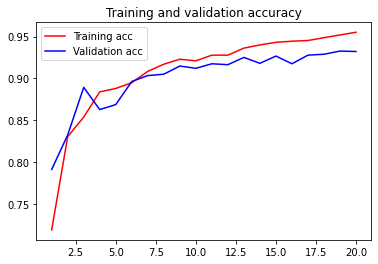

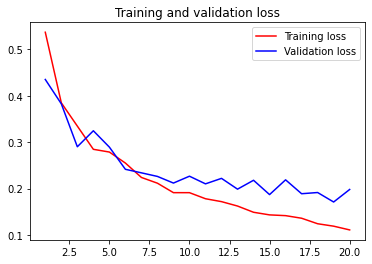

In [29]:
plot_accuracy(cnn_2_history)

In [30]:
cnn_2_pred_labels, labels = evaluate_model(cnn_2, test_ds, test_df)

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1046
           1       0.93      0.95      0.94      1259

    accuracy                           0.93      2305
   macro avg       0.94      0.93      0.93      2305
weighted avg       0.93      0.93      0.93      2305



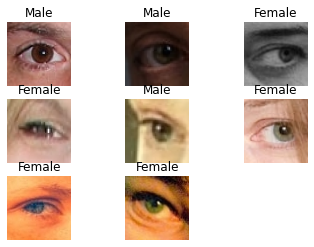

In [31]:
plot_missed_images(cnn_2_pred_labels, labels, test_df)

### 3.2 Transferência de conhecimento

Vamos utilizar modelos pré-feitos, e treinar a componente da classificação, uma vez que o nosso problema tem classes diferentes das utilizadas nestes modelos.

#### MobileNet

In [32]:
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
output = mobilenet.layers[-1].output
output = keras.layers.Flatten()(output)
mobilenet_model = Model(mobilenet.input, output)
mobilenet_model.trainable = False

In [33]:
mobilenet_cnn = Sequential()
mobilenet_cnn.add(mobilenet_model)
mobilenet_cnn.add(Dense(128, activation='relu'))
mobilenet_cnn.add(Dropout(0.3))
mobilenet_cnn.add(Dense(1, activation='sigmoid'))

mobilenet_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 16384)             3228864   
                                                                 
 dense_4 (Dense)             (None, 128)               2097280   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,326,273
Trainable params: 2,097,409
Non-trainable params: 3,228,864
_________________________________________________________________


In [34]:
start = dt.datetime.now()

mobilenet_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mobilenet_history = mobilenet_cnn.fit(train_ds_aug, epochs=epochs, callbacks=callbacks, validation_data=val_ds_aug, verbose=1)

end = dt.datetime.now()
time_mobilenet = end - start
print("O treino do modelo demorou " + str(time_mobilenet))

Epoch 1/20
148/148 [==============================] - 53s 349ms/step - loss: 0.4930 - accuracy: 0.8670 - val_loss: 0.2087 - val_accuracy: 0.9214
Epoch 2/20
148/148 [==============================] - 52s 350ms/step - loss: 0.2043 - accuracy: 0.9168 - val_loss: 0.2251 - val_accuracy: 0.9181
Epoch 3/20
148/148 [==============================] - 51s 345ms/step - loss: 0.1829 - accuracy: 0.9299 - val_loss: 0.1866 - val_accuracy: 0.9273
Epoch 4/20
148/148 [==============================] - 52s 352ms/step - loss: 0.1603 - accuracy: 0.9342 - val_loss: 0.1844 - val_accuracy: 0.9344
Epoch 5/20
148/148 [==============================] - 52s 349ms/step - loss: 0.1494 - accuracy: 0.9382 - val_loss: 0.2384 - val_accuracy: 0.9262
Epoch 6/20
148/148 [==============================] - 51s 346ms/step - loss: 0.1431 - accuracy: 0.9417 - val_loss: 0.1817 - val_accuracy: 0.9295
Epoch 7/20
148/148 [==============================] - 52s 351ms/step - loss: 0.1362 - accuracy: 0.9458 - val_loss: 0.1720 - val_ac

In [35]:
mobilenet_pred_labels, labels = evaluate_model(mobilenet_cnn, test_ds, test_df)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1046
           1       0.95      0.93      0.94      1259

    accuracy                           0.94      2305
   macro avg       0.94      0.94      0.94      2305
weighted avg       0.94      0.94      0.94      2305



In [36]:
modelFileName = '../models/mobilenet.h5'
mobilenet_cnn.save(modelFileName)
print('model saved as', modelFileName)

model saved as ../models/mobilenet.h5


#### VGG16

In [37]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
output = vgg16.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg16.input, output)
vgg_model.trainable = False

In [38]:
vgg16_cnn = Sequential()
vgg16_cnn.add(vgg_model)
vgg16_cnn.add(Dense(128, activation='relu'))
vgg16_cnn.add(Dropout(0.3))
vgg16_cnn.add(Dense(1, activation='sigmoid'))

vgg16_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 8192)              14714688  
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
start = dt.datetime.now()

vgg16_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg16_history = vgg16_cnn.fit(train_ds_aug, epochs=epochs, callbacks=callbacks, validation_data=val_ds_aug, verbose=1)

end = dt.datetime.now()
time_vgg16 = end - start
print("O treino do modelo demorou " + str(time_vgg16))

Epoch 1/20
148/148 [==============================] - 264s 2s/step - loss: 0.3769 - accuracy: 0.8252 - val_loss: 0.4752 - val_accuracy: 0.7684
Epoch 2/20
148/148 [==============================] - 270s 2s/step - loss: 0.2651 - accuracy: 0.8858 - val_loss: 0.2555 - val_accuracy: 0.8888
Epoch 3/20
148/148 [==============================] - 280s 2s/step - loss: 0.2345 - accuracy: 0.8989 - val_loss: 0.2250 - val_accuracy: 0.8970
Epoch 4/20
148/148 [==============================] - 271s 2s/step - loss: 0.2406 - accuracy: 0.8948 - val_loss: 0.2324 - val_accuracy: 0.8953
Epoch 5/20
148/148 [==============================] - 278s 2s/step - loss: 0.2206 - accuracy: 0.9070 - val_loss: 0.2090 - val_accuracy: 0.9078
Epoch 6/20
148/148 [==============================] - 294s 2s/step - loss: 0.2105 - accuracy: 0.9112 - val_loss: 0.2386 - val_accuracy: 0.9035
Epoch 7/20
148/148 [==============================] - 310s 2s/step - loss: 0.2008 - accuracy: 0.9159 - val_loss: 0.2142 - val_accuracy: 0.9078

In [40]:
vgg16_pred_labels, labels = evaluate_model(vgg16_cnn, test_ds, test_df)

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1046
           1       0.97      0.85      0.90      1259

    accuracy                           0.90      2305
   macro avg       0.90      0.91      0.90      2305
weighted avg       0.91      0.90      0.90      2305



In [41]:
modelFileName = '../models/vgg16.h5'
vgg16_cnn.save(modelFileName)
print('model saved as', modelFileName)

model saved as ../models/vgg16.h5


### InceptionV3

In [42]:
inceptionV3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
output = inceptionV3.layers[-1].output
output = keras.layers.Flatten()(output)
inceptionV3_model = Model(inceptionV3.input, output)
inceptionV3_model.trainable = False

In [43]:
inceptionV3_cnn = Sequential()
inceptionV3_cnn.add(inceptionV3_model)
inceptionV3_cnn.add(Dense(128, activation='relu'))
inceptionV3_cnn.add(Dropout(0.3))
inceptionV3_cnn.add(Dense(1, activation='sigmoid'))

inceptionV3_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 8192)              21802784  
                                                                 
 dense_8 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,851,617
Trainable params: 1,048,833
Non-trainable params: 21,802,784
_________________________________________________________________


In [44]:
start = dt.datetime.now()

inceptionV3_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
inceptionV3_history = inceptionV3_cnn.fit(train_ds_aug, epochs=epochs, callbacks=callbacks, validation_data=val_ds_aug, verbose=1)

end = dt.datetime.now()
time_inception = end - start
print("O treino do modelo demorou " + str(time_inception))

Epoch 1/20
148/148 [==============================] - 75s 489ms/step - loss: 0.6112 - accuracy: 0.7741 - val_loss: 0.3388 - val_accuracy: 0.8552
Epoch 2/20
148/148 [==============================] - 72s 484ms/step - loss: 0.3672 - accuracy: 0.8368 - val_loss: 0.2929 - val_accuracy: 0.8802
Epoch 3/20
148/148 [==============================] - 72s 487ms/step - loss: 0.3507 - accuracy: 0.8446 - val_loss: 0.3308 - val_accuracy: 0.8552
Epoch 4/20
148/148 [==============================] - 74s 497ms/step - loss: 0.3358 - accuracy: 0.8568 - val_loss: 0.2971 - val_accuracy: 0.8698
Epoch 5/20
148/148 [==============================] - 71s 483ms/step - loss: 0.3293 - accuracy: 0.8564 - val_loss: 0.2962 - val_accuracy: 0.8753
Epoch 6/20
148/148 [==============================] - 71s 481ms/step - loss: 0.3177 - accuracy: 0.8604 - val_loss: 0.2779 - val_accuracy: 0.8829
Epoch 7/20
148/148 [==============================] - 71s 477ms/step - loss: 0.3051 - accuracy: 0.8654 - val_loss: 0.2654 - val_ac

In [45]:
inceptionV3_pred_labels, labels = evaluate_model(inceptionV3_cnn, test_ds, test_df)

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1046
           1       0.90      0.92      0.91      1259

    accuracy                           0.90      2305
   macro avg       0.90      0.90      0.90      2305
weighted avg       0.90      0.90      0.90      2305



In [46]:
modelFileName = '../models/inceptionV3.h5'
inceptionV3_cnn.save(modelFileName)
print('model saved as', modelFileName)

model saved as ../models/inceptionV3.h5


### Xception

In [47]:
xcep = Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
output = xcep.layers[-1].output
output = keras.layers.Flatten()(output)
xcep_model = Model(xcep.input, output)
xcep_model.trainable = False

In [48]:
xcep_cnn = Sequential()
xcep_cnn.add(xcep_model)
xcep_cnn.add(Dense(128, activation='relu'))
xcep_cnn.add(Dropout(0.3))
xcep_cnn.add(Dense(1, activation='sigmoid'))

xcep_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 32768)             20861480  
                                                                 
 dense_10 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 25,056,041
Trainable params: 4,194,561
Non-trainable params: 20,861,480
_________________________________________________________________


In [49]:
start = dt.datetime.now()

xcep_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
xcep_history = xcep_cnn.fit(train_ds_aug, epochs=epochs, callbacks=callbacks, validation_data=val_ds_aug, verbose=1)

end = dt.datetime.now()
time_xcep = end - start
print("O treino do modelo demorou " + str(time_xcep))

Epoch 1/20
148/148 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.8391

c:\users\bruno\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


148/148 [==============================] - 144s 963ms/step - loss: 0.4411 - accuracy: 0.8391 - val_loss: 0.2955 - val_accuracy: 0.8785
Epoch 2/20
148/148 [==============================] - 138s 930ms/step - loss: 0.3142 - accuracy: 0.8693 - val_loss: 0.2721 - val_accuracy: 0.8807
Epoch 3/20
148/148 [==============================] - 135s 912ms/step - loss: 0.2897 - accuracy: 0.8761 - val_loss: 0.2694 - val_accuracy: 0.8921
Epoch 4/20
148/148 [==============================] - 143s 969ms/step - loss: 0.2633 - accuracy: 0.8917 - val_loss: 0.2596 - val_accuracy: 0.8877
Epoch 5/20
148/148 [==============================] - 153s 1s/step - loss: 0.2613 - accuracy: 0.8914 - val_loss: 0.2676 - val_accuracy: 0.8899
Epoch 6/20
148/148 [==============================] - 154s 1s/step - loss: 0.2515 - accuracy: 0.8960 - val_loss: 0.2452 - val_accuracy: 0.8986
Epoch 7/20
148/148 [==============================] - 144s 972ms/step - loss: 0.2523 - accuracy: 0.8994 - val_loss: 0.2439 - val_accuracy: 0.

In [50]:
xcep_pred_labels, labels = evaluate_model(xcep_cnn, test_ds, test_df)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1046
           1       0.89      0.94      0.91      1259

    accuracy                           0.90      2305
   macro avg       0.91      0.90      0.90      2305
weighted avg       0.90      0.90      0.90      2305



In [51]:
modelFileName = '../models/xception.h5'
xcep_cnn.save(modelFileName)
print('model saved as', modelFileName)

model saved as ../models/xception.h5


c:\users\bruno\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [52]:
acc_cnn_1 = str(len(set(cnn_1_pred_labels) & set(labels)) / float(len(set(cnn_1_pred_labels) | set(labels))) * 100)
acc_cnn_2 = str(len(set(cnn_2_pred_labels) & set(labels)) / float(len(set(cnn_2_pred_labels) | set(labels))) * 100)
acc_mobilenet = str(len(set(mobilenet_pred_labels) & set(labels)) / float(len(set(mobilenet_pred_labels) | set(labels))) * 100)
acc_vgg16 = str(len(set(vgg16_pred_labels) & set(labels)) / float(len(set(vgg16_pred_labels) | set(labels))) * 100)
acc_inceptionV3 = str(len(set(inceptionV3_pred_labels) & set(labels)) / float(len(set(inceptionV3_pred_labels) | set(labels))) * 100)
acc_xcep = str(len(set(xcep_pred_labels) & set(labels)) / float(len(set(xcep_pred_labels) | set(labels))) * 100)

In [53]:
def get_model_test_accuracy(predictions, originals):
    diff = 0
    for index, (first, second) in enumerate(zip(predictions, originals)):
        if first == second:
            diff += 1
    return round(diff / len(predictions), 2)

## Results - Summary

In [54]:
def convert_timedelta(duration):
    total_seconds = duration.seconds
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    return '{}h:{}m'.format(hours, minutes)

In [55]:
import decimal
models = [('CNN_1', convert_timedelta(time_CNN_1), decimal.Decimal(round(cnn_1_history.history['accuracy'][epochs-1], 2) * 100).normalize(),
                                     decimal.Decimal(round(cnn_1_history.history['val_accuracy'][epochs-1], 2) * 100).normalize(),
                                     decimal.Decimal(get_model_test_accuracy(cnn_1_pred_labels, labels) * 100).normalize()),
          ('CNN_2', convert_timedelta(time_CNN_2), decimal.Decimal(round(cnn_2_history.history['accuracy'][epochs-1], 2) * 100).normalize(),
                                     decimal.Decimal(round(cnn_2_history.history['val_accuracy'][epochs-1], 2) * 100).normalize(),
                                     decimal.Decimal(get_model_test_accuracy(cnn_2_pred_labels, labels) * 100).normalize()),
          ('MobileNet', convert_timedelta(time_mobilenet), decimal.Decimal(round(mobilenet_history.history['accuracy'][epochs-1], 2) * 100).normalize(),
                                             decimal.Decimal(round(mobilenet_history.history['val_accuracy'][epochs-1], 2) * 100).normalize(),
                                             decimal.Decimal(get_model_test_accuracy(mobilenet_pred_labels, labels) * 100).normalize()),
          ('VGG16', convert_timedelta(time_vgg16), decimal.Decimal(round(vgg16_history.history['val_accuracy'][epochs-1], 2) * 100).normalize(),
                                             decimal.Decimal(round(vgg16_history.history['val_accuracy'][epochs-1], 2) * 100).normalize(),
                                             decimal.Decimal(get_model_test_accuracy(vgg16_pred_labels, labels) * 100).normalize()),
          ('Inception', convert_timedelta(time_inception), decimal.Decimal(round(inceptionV3_history.history['accuracy'][epochs-1], 2) * 100).normalize(),
                                             decimal.Decimal(round(inceptionV3_history.history['val_accuracy'][epochs-1], 2) * 100).normalize(),
                                             decimal.Decimal(get_model_test_accuracy(inceptionV3_pred_labels, labels) * 100).normalize()),
          ('Xception', convert_timedelta(time_xcep), decimal.Decimal(round(xcep_history.history['accuracy'][epochs-1], 2) * 100).normalize(),
                                             decimal.Decimal(round(xcep_history.history['val_accuracy'][epochs-1], 2) * 100).normalize(),
                                             decimal.Decimal(get_model_test_accuracy(xcep_pred_labels, labels) * 100).normalize())]

df_all_models = pd.DataFrame(models, columns=['Model', 'Time', 'Training accuracy (%)', 'Validation Accuracy (%)', 'Test Accuracy (%)'])

df_all_models

,Model,Time,Training accuracy (%),Validation Accuracy (%),Test Accuracy (%)
0,CNN_1,0h:25m,95,93,93
1,CNN_2,0h:25m,96,93,93
2,MobileNet,0h:33m,97,93,94
3,VGG16,1h:36m,9E+1,9E+1,9E+1
4,Inception,0h:24m,88,89,9E+1
5,Xception,0h:48m,93,9E+1,9E+1


In [ ]:
## Predictions

In [138]:
# Prediction function
def predict_image(model, image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Image needs to be in the form of a batch
    img_array = tf.expand_dims(img_array, 0)/255

    # Predict & score
    predictions = model.predict(img_array)
    score = predictions[0]
    print("This image is %.2f percent female and %.2f percent male." % (100 * (1 - score), 100 * score))
    plt.imshow(img)

This image is 0.52 percent female and 99.48 percent male.


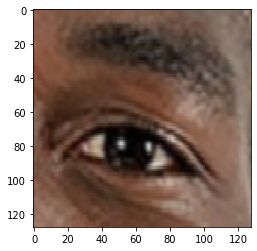

In [139]:
predict_image(cnn_1, "../dataset/negro_homem.png")

This image is 25.08 percent female and 74.92 percent male.


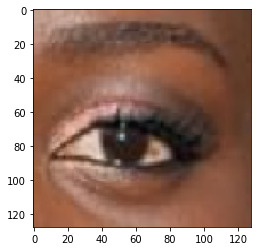

In [140]:
predict_image(cnn_1, "../dataset/negro_mulher.png")

This image is 0.30 percent female and 99.70 percent male.


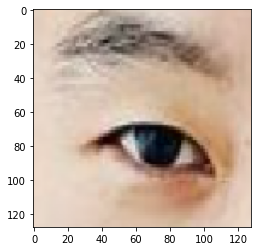

In [141]:
predict_image(cnn_1, "../dataset/asiatico_homem.png")

This image is 8.35 percent female and 91.65 percent male.


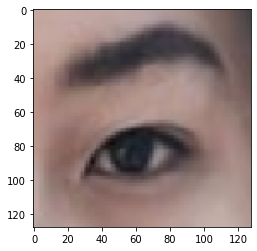

In [142]:
predict_image(cnn_1, "../dataset/asiatico_mulher.png")

This image is 0.65 percent female and 99.35 percent male.


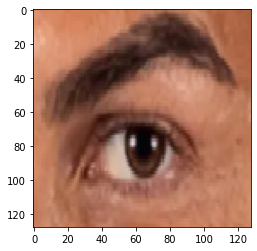

In [143]:
predict_image(cnn_1, "../dataset/claro_homem_sobrancelha.png")

This image is 94.35 percent female and 5.65 percent male.


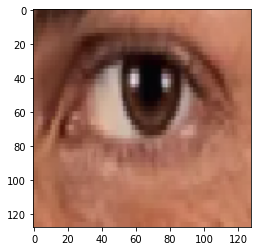

In [144]:
predict_image(cnn_1, "../dataset/claro_homem_sem_sobrancelha.png")

This image is 96.84 percent female and 3.16 percent male.


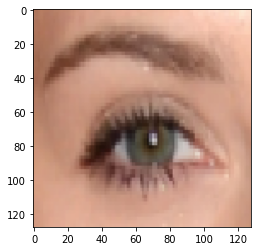

In [145]:
predict_image(cnn_1, "../dataset/clara_mulher.png")

This image is 0.06 percent female and 99.94 percent male.


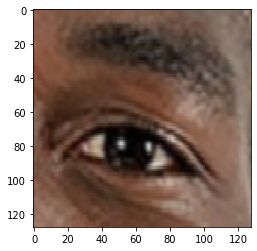

In [146]:
predict_image(cnn_2, "../dataset/negro_homem.png")

This image is 19.88 percent female and 80.12 percent male.


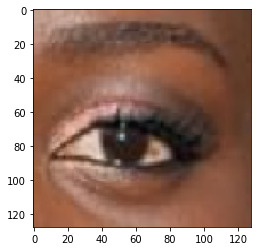

In [147]:
predict_image(cnn_2, "../dataset/negro_mulher.png")

This image is 0.17 percent female and 99.83 percent male.


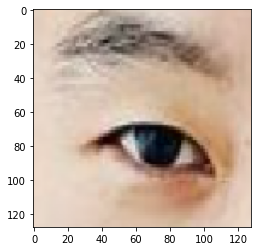

In [148]:
predict_image(cnn_2, "../dataset/asiatico_homem.png")

This image is 1.41 percent female and 98.59 percent male.


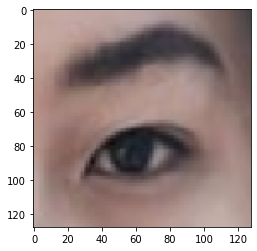

In [149]:
predict_image(cnn_2, "../dataset/asiatico_mulher.png")

This image is 8.28 percent female and 91.72 percent male.


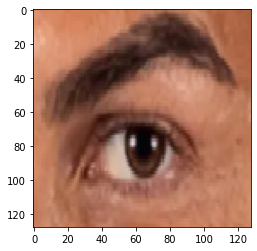

In [150]:
predict_image(cnn_2, "../dataset/claro_homem_sobrancelha.png")

This image is 97.46 percent female and 2.54 percent male.


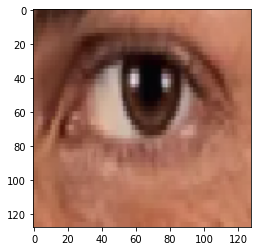

In [151]:
predict_image(cnn_2, "../dataset/claro_homem_sem_sobrancelha.png")

This image is 98.67 percent female and 1.33 percent male.


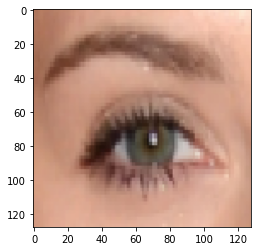

In [152]:
predict_image(cnn_2, "../dataset/clara_mulher.png")

This image is 0.00 percent female and 100.00 percent male.


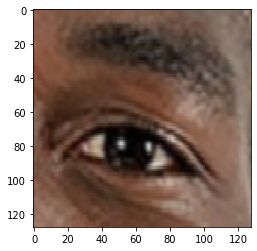

In [153]:
predict_image(mobilenet_cnn, "../dataset/negro_homem.png")

This image is 99.04 percent female and 0.96 percent male.


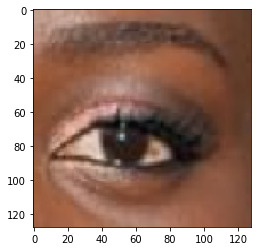

In [154]:
predict_image(mobilenet_cnn, "../dataset/negro_mulher.png")

This image is 3.33 percent female and 96.67 percent male.


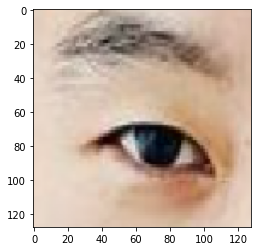

In [155]:
predict_image(mobilenet_cnn, "../dataset/asiatico_homem.png")

This image is 30.78 percent female and 69.22 percent male.


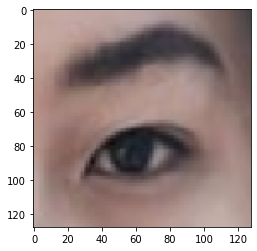

In [156]:
predict_image(mobilenet_cnn, "../dataset/asiatico_mulher.png")

This image is 50.60 percent female and 49.40 percent male.


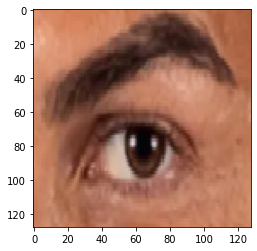

In [162]:
predict_image(mobilenet_cnn, "../dataset/claro_homem_sobrancelha.png")

This image is 6.87 percent female and 93.13 percent male.


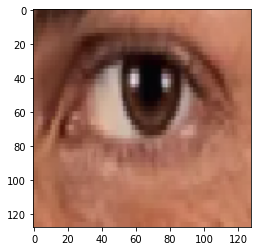

In [161]:
predict_image(mobilenet_cnn, "../dataset/claro_homem_sem_sobrancelha.png")

This image is 100.00 percent female and 0.00 percent male.


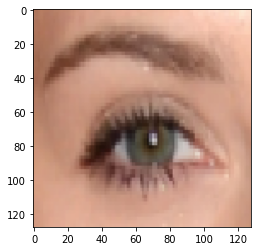

In [159]:
predict_image(mobilenet_cnn, "../dataset/clara_mulher.png")